<a href="https://colab.research.google.com/github/SSandeepk2001/Ai_Tutor/blob/main/Model_Building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries
import pandas as pd
import numpy as np
import re, string, time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import files
uploaded = files.upload()

Saving IELTS_dataset02.csv to IELTS_dataset02.csv


In [3]:
# Load & Preprocess Dataset
df = pd.read_csv("/content/IELTS_dataset02.csv")
df['band'] = df['band'].str.extract(r'(\d+\.?\d*)').astype(float)  # Clean band
df.dropna(subset=['essay', 'band'], inplace=True)

In [4]:
# Clean essay text
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

df['clean_essay'] = df['essay'].apply(clean_text)

In [5]:
# Define Features & Target
X = df['clean_essay']
y = df['band']

In [6]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# 4: Model Building
tfidf = TfidfVectorizer(max_features=5000)

models = {
    'Ridge': Ridge(),
    'RandomForest': RandomForestRegressor(n_estimators=50, n_jobs=-1),
    'SVR': SVR(),
    'XGBoost': XGBRegressor(n_estimators=50, n_jobs=-1, verbosity=0)
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    start = time.time()
    pipe = Pipeline([('tfidf', tfidf), ('model', model)])
    pipe.fit(X_train[:5000], y_train[:5000])  # use subset for faster Colab run
    preds = pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    results[name] = {'RMSE': rmse, 'R2': r2, 'Time (s)': time.time() - start}
    print(f"{name} -> RMSE: {rmse:.3f}, R2: {r2:.3f}")


Training Ridge...
Ridge -> RMSE: 1.183, R2: 0.237

Training RandomForest...
RandomForest -> RMSE: 1.174, R2: 0.250

Training SVR...
SVR -> RMSE: 1.173, R2: 0.251

Training XGBoost...
XGBoost -> RMSE: 1.190, R2: 0.228


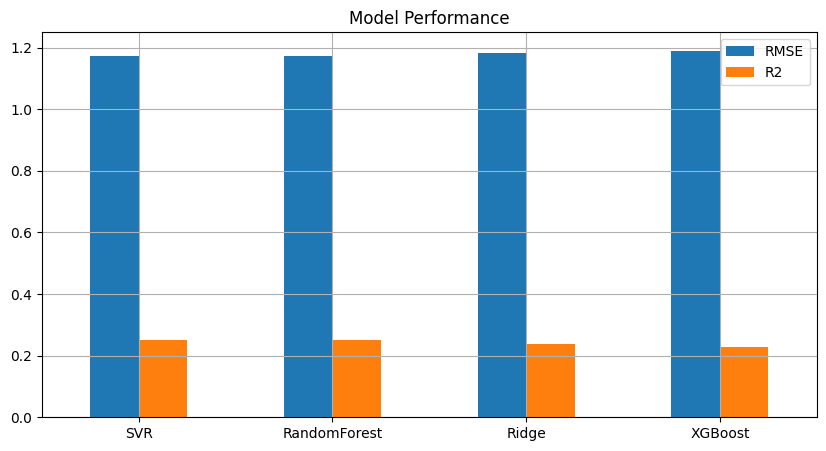

In [8]:
# Visualize Results
results_df = pd.DataFrame(results).T
results_df.sort_values("RMSE", inplace=True)
results_df[['RMSE', 'R2']].plot(kind='bar', figsize=(10,5), title='Model Performance')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

In [9]:
# Optional Hyperparameter Tuning on Best Model (example: Ridge)
param_grid = {'model__alpha': [0.01, 0.1, 1, 10]}
ridge_pipe = Pipeline([('tfidf', tfidf), ('model', Ridge())])
grid = GridSearchCV(ridge_pipe, param_grid, cv=3, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)
print("Best Ridge Parameters:", grid.best_params_)
best_model = grid.best_estimator_

Best Ridge Parameters: {'model__alpha': 1}


In [10]:
# Retry training models using only single-threaded mode to avoid parallel threading issues in limited environments
# Also reduce dataset for heavy models to avoid crashes

models_single = {
    'Ridge': Ridge(),
    'SVR': SVR(),
    'XGBoost': XGBRegressor(n_estimators=30, n_jobs=1, verbosity=0),
    'RandomForest': RandomForestRegressor(n_estimators=30, n_jobs=1)
}

results_single = {}
best_model_single = None
best_rmse_single = float('inf')

for name, model in models_single.items():
    print(f"Training {name} (single-threaded)...")
    start = time.time()
    pipe = Pipeline([('tfidf', tfidf), ('model', model)])
    pipe.fit(X_train[:5000], y_train[:5000])  # use subset for efficiency
    preds = pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    duration = time.time() - start
    results_single[name] = {'RMSE': rmse, 'R2': r2, 'Time': duration}
    print(f"{name} -> RMSE: {rmse:.3f}, R2: {r2:.3f}, Time: {duration:.2f}s")
    if rmse < best_rmse_single:
        best_rmse_single = rmse
        best_model_single = pipe

Training Ridge (single-threaded)...
Ridge -> RMSE: 1.183, R2: 0.237, Time: 1.47s
Training SVR (single-threaded)...
SVR -> RMSE: 1.173, R2: 0.251, Time: 59.62s
Training XGBoost (single-threaded)...
XGBoost -> RMSE: 1.195, R2: 0.222, Time: 18.29s
Training RandomForest (single-threaded)...
RandomForest -> RMSE: 1.173, R2: 0.251, Time: 124.34s


In [11]:
# Save best model from single-threaded tests
joblib.dump(best_model_single, 'best_model_single.pkl')

# Show results
pd.DataFrame(results_single).T

,RMSE,R2,Time
Ridge,1.183400,0.237266,1.473084
SVR,1.173088,0.250501,59.619811
XGBoost,1.194874,0.222404,18.286676
RandomForest,1.172620,0.251098,124.336658
